In [1]:
from Bio import SeqIO
import json
from collections import Counter, defaultdict
import subprocess # to run blastn
from sklearn.metrics import classification_report, f1_score # for eval
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Class dictionairies
with open("train_classes.json") as f:
    train_classes = json.load(f)

with open("test_classes.json") as f:
    test_classes = json.load(f)

In [3]:
# overall majority class (use if there's no hits at all)
overall_majority = Counter(list(train_classes.values())).most_common(1)[0][0]

print('Most common class in train set: ', overall_majority)

Most common class in train set:  NRP


In [4]:
def run_blastn(test_fasta, db, output_file, k = 10):
    # This runs blastn and outputs test ID, and k similar train IDs
    subprocess.run([
        "./ncbi-blast-2.16.0+/bin/blastn",
        "-query", test_fasta,
        "-db", db,
        "-out", output_file,
        # Needed for a tsv output, we only need these fields for our algo
        "-outfmt", "6 qseqid sseqid pident length evalue bitscore",
        "-max_target_seqs", str(k) # blastn will return at most k
    ], check=True)
    
def read_blast_output(blast_output):
    test_to_NN = defaultdict(list) # test instance -> k nearest neighbors
    with open(blast_output) as f:
        for line in f: 
            # train id is the blast hits
            test_id, train_id, *_ = line.strip().split("\t")
            test_to_NN[test_id].append(train_id)
    return test_to_NN

# This is our blast kNN implementation
def predict_class(test_to_NN, train_classes, k = 10):
    preds = {}
    for test_id, train_ids in test_to_NN.items():
        train_ids = train_ids[:k] # top k ids only
        # the classes for the top k ids
        k_classes = [train_classes.get(train_id) for train_id in train_ids if train_classes.get(train_id) is not None]
        
        if k_classes: # find majority
            majority = Counter(k_classes).most_common(1)[0][0]
        else: # edge case: no hits 
            majority = overall_majority
            
        preds[test_id] = majority
        
    return preds  

In [5]:
# Returns metrics to compare with DGEB
def eval_metrics(preds, test_classes):
    y_pred = []
    y_true = []
    
    for test_id, true_class in test_classes.items():
        y_pred.append(preds.get(test_id, overall_majority))
        y_true.append(true_class)
        
    # sklearn eval metrics
    report = classification_report(y_true, y_pred, output_dict = False)
    
    f1 = f1_score(y_true, y_pred, average = 'macro')
    
    return f1, report

In [6]:
# Run the algorithm for different k's
blast_output = "blast_results.tsv"
test_fasta = "mibig_test.fasta"
db = "mibig_train_db" # this is our local blastdb

ks = list(range(1, 15))
f1s = []
best_f1 = 0
best_report = None
best_k = None

# Only need to run once, with highest k!
run_blastn(test_fasta, db, blast_output, k = 15)

for k in ks:
    test_to_NN = read_blast_output(blast_output)
    preds = predict_class(test_to_NN, train_classes, k)
    f1, report = eval_metrics(preds, test_classes)
    
    f1s.append(f1)
    
    if f1 > best_f1:
        best_f1 = f1
        best_report = report
        best_k = k

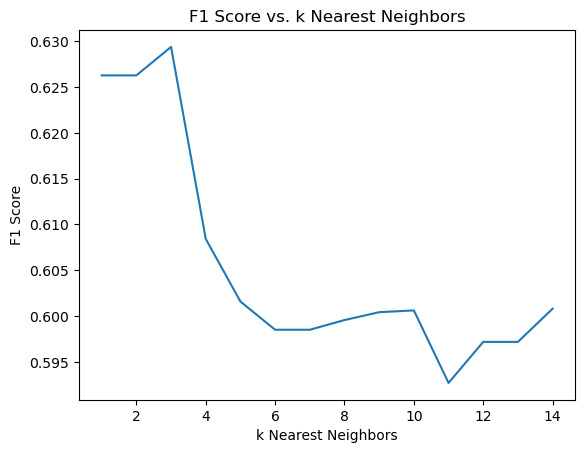

The k with the highest F1 Score is k =  3
Best F1 Score: 0.629


Classification Report:
               precision    recall  f1-score   support

    Alkaloid       0.50      0.17      0.25        12
         NRP       0.60      0.89      0.72       163
  Polyketide       0.82      0.73      0.77       138
        RiPP       1.00      0.48      0.65        67
  Saccharide       1.00      0.79      0.88        28
     Terpene       0.72      0.39      0.51        33

    accuracy                           0.71       441
   macro avg       0.77      0.57      0.63       441
weighted avg       0.76      0.71      0.71       441



In [7]:
plt.plot(ks, f1s)
plt.xlabel("k Nearest Neighbors")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. k Nearest Neighbors")
plt.show()

print('The k with the highest F1 Score is k = ', best_k)
print("Best F1 Score: {:.3f}".format(best_f1))

print('\n\nClassification Report:\n', best_report)

In [8]:
print('Macro F1s:\n', f1s)

Macro F1s:
 [0.6262705878107212, 0.6262705878107212, 0.62937738515043, 0.6084223374995369, 0.6015849122501249, 0.5985063040614206, 0.5985063040614206, 0.5995642877033854, 0.6004236693257602, 0.6006179781587423, 0.5927028720413889, 0.5971816150465744, 0.5971816150465744, 0.6008037790708675]
